In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Early Stopping & Transfer learning

Sometimes training to long (to many epochs) leads to overfitting. This means, that the model learn the attributes of the training data very well, but generalizes less well to new data (like validation and test data). Models with a lot of trainable parameters are especially prone to overfitting, because they can adjust to the training data very well.  

So what can we do? One way to reduce the risk of overfitting is training on more data, so that the model learn the variablity in the data better. Since that's not always possible, data can be artificially augmented. If you are interested in that, have a look in the corresponding notebook.  

Here, we will look at another technique to reduce the risk of overfitting, namely ``EarlyStopping``. ``EarlyStopping`` means that we stop the training, when the generalization error increases.  

Additionally we will use transfer learning. This means, that we will use the weights that have been trained on another (but huge) dataset (like ImageNet). Useing these weights initially (and finetuning them later) is generally preferable to randomly using random weights. If you want to know more about transfer learning, have a look in the notebook about transfer learning.

But fist, the data need to be loaded.

## Downloading and preparing the data

First, the data need to be loaded and prepared for ``AUCMEDI``.  
If you have questions concering that part, just have a look in the corresponding notebook.

In [2]:
from pathlib import Path
import wget
import zipfile

cwd = !pwd
datadir = cwd[0] + "/data"
Path(datadir).mkdir(parents=True, exist_ok=True)

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], 
                                         stratified=True, iterative=False, seed=123)

2022-07-27 09:59:09.661838: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Define the model

Now the model can be defined. If you have questions regarding that, have a look in the notebook about CustomArchitecutre. There the model definition is expained.

In [3]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)

model = NeuralNetwork(n_labels=nclasses, channels=3, architecture="2D.ResNet50", 
                      loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], 
                      activation_output="softmax", pretrained_weights=True)

2022-07-27 09:59:12.987831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 09:59:13.605744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


## Train the model

Now, the model can be trained.  

Everything is as usual, but we are defining two callbacks, an ``EarlyStopping`` callback and a ``ModelCheckpoint`` callback. 

With the ``EarlyStopping`` callback we tell ``AUCMEDI``, when the training should be stopped. Here we are monitoring the validation loss and if it gets worse (i.e. increases) for 10 epochs (patience=10) the training is stopped.

The ``ModelCheckpoint`` is to save the best model regarding the validation loss. We can later load this model and perform the predictions with this (the best) model and not the last version.

The number of epochs is set to 100, because training will be stopped due to ``EarlyStopping`` anyways.

In [4]:
import tensorflow as tf

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./model.h5', monitor='val_loss', save_best_only=True)

In [5]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=True, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=True, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=100, iterations=None, 
                                         callbacks=[earlyStopping, modelCheckpoint], class_weights=None, transfer_learning=True)

A directory for image preparation was created: /tmp/aucmedi.tmp.akbsrgxl.data
A directory for image preparation was created: /tmp/aucmedi.tmp.n7ysel4v.data
Epoch 1/10


2022-07-27 09:59:22.582626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-27 09:59:23.124615: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 13s 108ms/step - loss: 0.9357 - categorical_accuracy: 0.6920 - f1_score: 0.6829 - val_loss: 0.3374 - val_categorical_accuracy: 0.8840 - val_f1_score: 0.8843
Epoch 2/10
79/79 [==============================] - 7s 92ms/step - loss: 0.4022 - categorical_accuracy: 0.8656 - f1_score: 0.8636 - val_loss: 0.3241 - val_categorical_accuracy: 0.8888 - val_f1_score: 0.8864
Epoch 3/10
79/79 [==============================] - 8s 101ms/step - loss: 0.3227 - categorical_accuracy: 0.8892 - f1_score: 0.8873 - val_loss: 0.2532 - val_categorical_accuracy: 0.9192 - val_f1_score: 0.9132
Epoch 4/10
79/79 [==============================] - 7s 93ms/step - loss: 0.2595 - categorical_accuracy: 0.9120 - f1_score: 0.9101 - val_loss: 0.2435 - val_categorical_accuracy: 0.9152 - val_f1_score: 0.9163
Epoch 5/10
79/79 [==============================] - 8s 95ms/step - loss: 0.2152 - categorical_accuracy: 0.9268 - f1_score: 0.9263 - val_loss: 0.2405 - val_categorical_accuracy: 0.9

Let's have a look at the training history:

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.validation.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

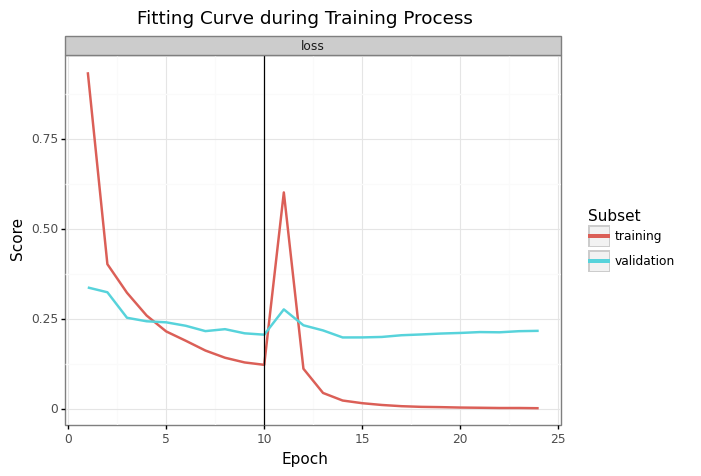

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

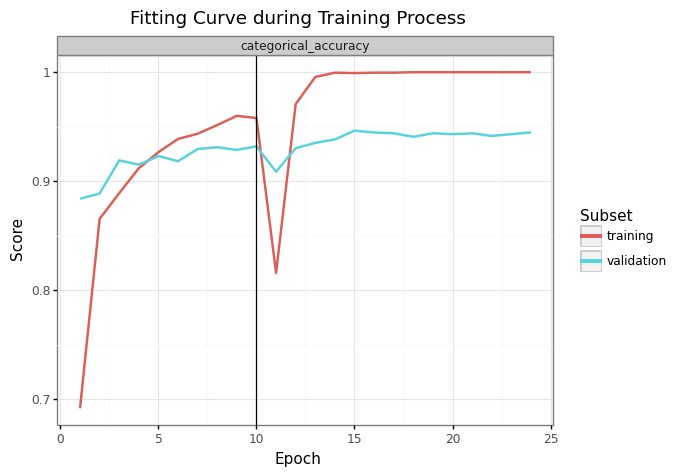

In [6]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="validation",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

The vertical bar indicates epochs with frozen weights (left site of the bar, epochs 1 to 10) and epochs that were the weights were finetuned (here epochs 11 to 24).  

After unfreezing the weights (in epoch 11) the training accuracy goes down and the loss up at first, because the correct weights have to be found first. (Remember that we previously used the weights that were trained on a different task, so now they have to be adapted to the classification task at hand.)

For the validation accuracy and loss the drop/increase is not so obvious, because it is calculated differently: While tensorflow calculates the metrics for the training set for each epoch, a mean of all previous epochs is calculated for the validation-test.

In [7]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=model.meta_input, standardize_mode=model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)


## Load best model

So let's load the best model (that we saved with the ``ModelCheckpoint``) and perform the predictions.

In [8]:
model.load(file_path='./model.h5')
prediction = model.predict(prediction_generator=predict_generator)

40/40 [==============================] - 5s 91ms/step


Now we can use ``AUCMEDI``s ``evaluate_performace`` function to get statistics and plots on the performance of the best model on the test-data.

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

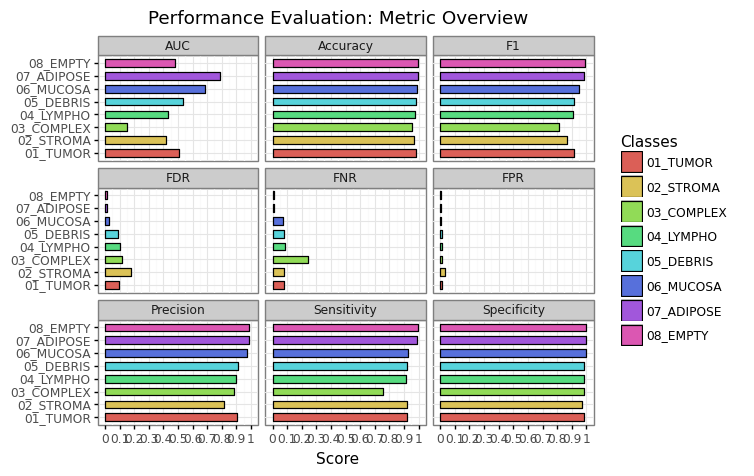

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.confusion_matrix.png


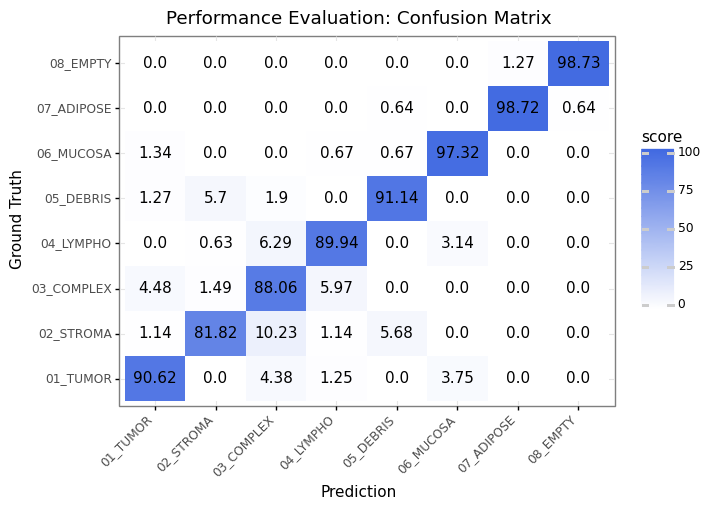

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:236: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.roc.png


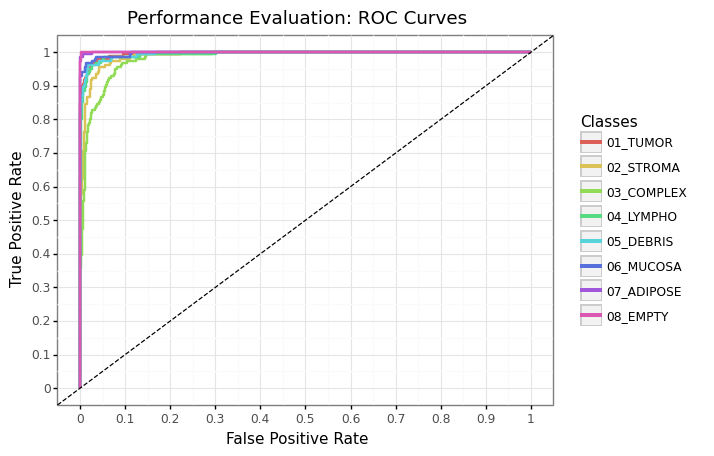

,metric,score,class
0,TP,145.000000,01_TUMOR
1,TN,1078.000000,01_TUMOR
2,FP,15.000000,01_TUMOR
3,FN,12.000000,01_TUMOR
4,Sensitivity,0.923567,01_TUMOR
...,...,...,...
99,FNR,0.006369,08_EMPTY
100,FDR,0.012658,08_EMPTY
101,Accuracy,0.997600,08_EMPTY
102,F1,0.990476,08_EMPTY


In [9]:
from aucmedi import *
from aucmedi.evaluation.performance import *

evaluate_performance(prediction, test[1], out_path="./", class_names=class_names, show=True)